# Risque Sécheresse 

**Mesure du degré de sécheresse associé à la localisation donnée (utilisation d'une mesure de degré de gonflement/retrait d'argile pour refléter le niveau de sécheresse).**

* Importation des packages nécessaires (pour data visualisation, manipulation de données géographiques) 
* Création de la carte de sécheresse du département considéré (associé à l'adresse de l'utilisateur) + précision de l'adresse précise sur cette carte 
* Calcul d'un score moyen de sécheresse dans le département 



##### Packages nécessaires à installer/importer

**Importation et installation des packages nécessaires :**

In [1]:
pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install contextily

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug
!pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
!pip install py7zr #Sur colab, sinon bug
!pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .


Defaulting to user installation because normal site-packages is not writeable
  Using cached botocore-1.23.26-py3-none-any.whl (8.5 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.27.59
    Uninstalling botocore-1.27.59:
      Successfully uninstalled botocore-1.27.59
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.4.1 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.23.26 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
  Using cached urllib3-1.22-py2.py3-none-any.whl (132 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.13
    Uninstalling urllib3-1.26.13:
      Successfully uninstalled urllib3-1.26.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

Defaulting to user installation because normal site-packages is not writeable
Processing /home/gregoire/Python/ProjPythonENSAE2022/ProjPython/cartogether
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cartiflette: filename=cartiflette-0.0.1-py3-none-any.whl size=19629 sha256=b4847a37775864d7ed86c0038453f6fe42dbdd5dab419d7b6a768ab310b74ce0
  Stored in directory: /tmp/pip-ephem-wheel-cache-9o7db860/wheels/f4/b3/8f/2147229f24196ae8874440ac7bad9db2e287b08af2d61a7620
Successfully built cartiflette


  Attempting uninstall: cartiflette
    Found existing installation: cartiflette 0.0.1
    Uninstalling cartiflette-0.0.1:
      Successfully uninstalled cartiflette-0.0.1


In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [6]:
import geopandas as gpd 
import contextily as ctx

##### Informations entrées par l'utilisateur 

**Entrées de l'utilisateur :**

In [2]:
#Entree par l'utilisateur de info sur son domicile 
dep = (input("Departement"))
num = int(input("Numero"))
nom_voie = input("Nom de la voie")
ville = input('Ville')
code_postal = input("Code postal")

Departement44
Numero4
Nom de la voieRue Fouré
VilleNantes
Code postal44000


#### **Fonction principale : mesure et visualisation du niveau de sécheresse à proximité de l'adresse postale donnée**

In [33]:
def secheresse(dep,num,nom_voie,ville,code_postal):

  #Récupération des données concernant le domicile de l'utilisateur 
  adresses_dep = pd.read_csv("https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-"+dep+".csv.gz", compression='gzip', sep=";", error_bad_lines=False) #recuperation des adresses postales correspondant au département de l'utilisateur
  foyer_infos = adresses_dep[(adresses_dep["numero"] == num) & (adresses_dep["nom_commune"] == ville) & (adresses_dep["nom_voie"] == nom_voie)] 

  df_secheresse = gpd.read_file("DataSets/AleaRG"+dep+"_L93/AleaRG"+dep+"_L93.shp") #dataframe contenant les zones arigleuses du département donné 
  df_secheresse.to_csv() #conversion du fichier en csv 


  #Calcul du score moyen de "sécheresse" (i.e. niveau de gonflement/retrait d'argile, échelle de 1 à 3) du département considéré 
  argile_dep = np.mean(df_secheresse["niveau"])

  #Conversion des coordonnées GPS d'un point en une géométrie exploitable sur Geopandas 
  geometry = gpd.points_from_xy(foyer_infos["lon"], foyer_infos["lat"])

  #Création des dataframe avec geométrie du point à localiser 
  geo_foyer = gpd.GeoDataFrame(foyer_infos, crs="EPSG:4326", geometry=geometry)
  geo_foyer.crs
  #print(geo_foyer) #TEST 

  df_1 = df_secheresse[df_secheresse.niveau == 1]
  df_2 = df_secheresse[df_secheresse.niveau == 2]
  df_3 = df_secheresse[df_secheresse.niveau == 3]
  df_1.crs
  df_2.crs
  df_3.crs 
  df_secheresse.crs

  #print(df_secheresse.head()) #TEST

  #Cartographie des zones de sécheresse (selon le degré de gonflement/retrait des argiles) dans le département 31 
  fig,ax = plt.subplots(figsize=(10, 10)) 
  df_1.to_crs(3857).plot(ax = ax, color ='yellow', alpha = 0.6,zorder=2)
  df_2.to_crs(3857).plot(ax = ax, color ='orange', alpha = 0.6,zorder=2)
  df_3.to_crs(3857).plot(ax = ax, color ='red', alpha = 0.6,zorder=2)
  geo_foyer.to_crs(3857).plot(ax=ax, color="black",zorder=2)
  ax.set_title("Cartographie des zones de sécheresse préocupantes en Haute-Garonne")
  fig.legend()
  ctx.add_basemap(ax=ax,source=ctx.providers.OpenStreetMap.Mapnik)
  plt.show()

  #Fonction position géographique de l'habitation -> risque sécheresse précis associé
  
  
  print("Le score de sécheresse (de 1 à 5) de l'habitation est de :"+str(argile_dep*(5/3)))
  return(argile_dep*(5/3))



/tmp/ipykernel_23899/4160434888.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  adresses_dep = pd.read_csv("https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-"+dep+".csv.gz", compression='gzip', sep=";", error_bad_lines=False) #recuperation des adresses postales correspondant au département de l'utilisateur
/tmp/ipykernel_23899/4160434888.py:4: DtypeWarning: Columns (9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  adresses_dep = pd.read_csv("https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-"+dep+".csv.gz", compression='gzip', sep=";", error_bad_lines=False) #recuperation des adresses postales correspondant au département de l'utilisateur
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


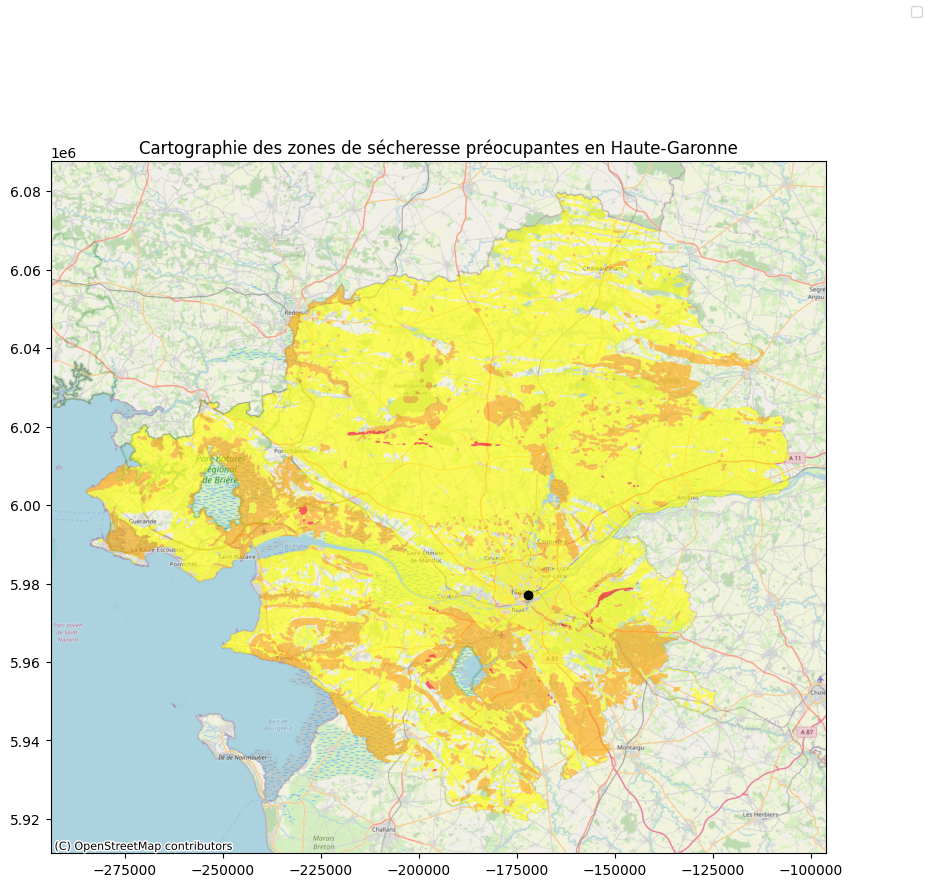

Le score de sécheresse (de 1 à 5) de l'habitation est de :1.5509838998211092


2.5849731663685156

In [34]:
secheresse(dep,num,nom_voie,ville,code_postal)

#### Mesure du risque sécheresse précis pour l'habitation considérée
#### Déjà inclu dans la fonction principale mais si vous voulez récupérer la fonction : 

In [29]:
#Fonction position géographique de l'habitation -> risque sécheresse précis associé
def risque(geometry):
  for k in range(len(df_secheresse["geometry"])):
    if df_secheresse["geometry"].contains(geometry):
      risque.append(df_secheresse["alea"][k])
  
  return(risque)

In [30]:
print(risque(geo_foyer["geometry"]))

/home/gregoire/.local/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/tmp/ipykernel_23899/3930876961.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2154
Right CRS: EPSG:4326

  if df_secheresse["geometry"].contains(geometry):


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().